In [1]:
from utils import *
%matplotlib inline

# Create a neural network

<center><img src="support/neuralnetwork.gif" width=500></center>

Now let's look how to create neural networks in Gluon. In addition the NDArray package (`nd`) that we just covered, we now will also import the neural network `nn` package from `gluon`.

In [2]:
import mxnet as mx

from mxnet import nd
from mxnet.gluon import nn

## Create your first neural network layer

Let's start with a dense layer with 2 output units.
The None is because there hasn't been any data passed in yet

<center><img src="support/fullyconnected.png" width=400></center>

In [3]:
layer = nn.Dense(3, activation="relu")
layer

Dense(None -> 3, Activation(relu))

Then initialize its weights with the default initialization method, which draws random values uniformly from $[-0.7, 0.7]$.

Initialization

In [4]:
layer.params

dense0_ (
  Parameter dense0_weight (shape=(3, 0), dtype=float32)
  Parameter dense0_bias (shape=(3,), dtype=float32)
)

In [5]:
layer.initialize(mx.init.Xavier())

Then we do a forward pass with random data. We create a $(3,4)$ shape random input `x` and feed into the layer to compute the output.

Forward with input `x`

In [6]:
N = 2
x = nd.random.uniform(low=-1, high=1, shape=(N, 4))
x


[[ 0.09762704  0.18568921  0.43037868  0.68853152]
 [ 0.20552671  0.71589124  0.08976638  0.69450343]]
<NDArray 2x4 @cpu(0)>

In [7]:
output = layer(x)
output


[[ 0.          0.          0.        ]
 [ 0.01030675  0.          0.        ]]
<NDArray 2x3 @cpu(0)>

Inferred shape

In [8]:
layer.params

dense0_ (
  Parameter dense0_weight (shape=(3, 4), dtype=float32)
  Parameter dense0_bias (shape=(3,), dtype=float32)
)

As can be seen, the layer's input limit of 2 produced a $(3,2)$ shape output from our $(3,4)$ input. Note that we didn't specify the input size of `layer` before (though we can specify it with the argument `in_units=4` here), the system will automatically infer it during the first time we feed in data, create and initialize the weights. So we can access the weight after the first forward pass:

Weights

In [9]:
layer.weight.data()


[[-0.14136386  0.22879553  0.27014339 -0.21408349]
 [-0.11556607 -0.37489307  0.72542262 -0.82080805]
 [ 0.8585366  -0.42095876 -0.21582437 -0.04135615]]
<NDArray 3x4 @cpu(0)>

## Chain layers into a neural network

Let's first consider a simple case that a neural network is a chain of layers. During the forward pass, we run layers sequentially one-by-one. The following code implements a famous network called [LeNet](http://yann.lecun.com/exdb/lenet/) through `nn.Sequential`.

<center><img src="support/lenet.jpg"></center>

In [10]:
net = nn.Sequential()
with net.name_scope():
    # Add a sequence of layers.
    net.add(
        nn.Conv2D(channels=6, kernel_size=(5, 5), activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
   
        nn.Dense(120, activation="relu"),
        nn.Dense(84, activation="relu"),
        
        nn.Dense(10)
    )
net

Sequential(
  (0): Conv2D(None -> 6, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (2): Conv2D(None -> 16, kernel_size=(5, 5), stride=(1, 1))
  (3): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (4): Flatten
  (5): Dense(None -> 120, Activation(relu))
  (6): Dense(None -> 84, Activation(relu))
  (7): Dense(None -> 10, linear)
)

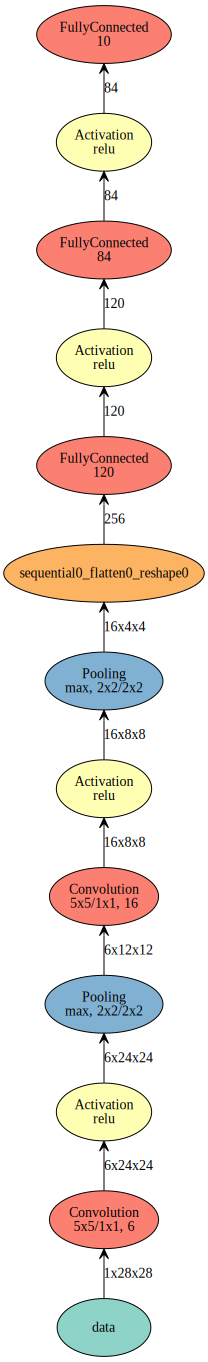

In [11]:
mx.viz.plot_network(net(mx.sym.var('data')), 
                    shape={"data":(1, 1, 28, 28)},
                    node_attrs={"shape":"oval","fixedsize":"False"},
                   )

<!--Mention the tuple option for kernel and stride as an exercise for the reader? Or leave it out as too much info for now?-->

The usage of `nn.Sequential` is similar to `nn.Dense`. In fact, both of them are subclasses of `nn.Block`. The following codes show how to initialize the weights and run the forward pass.

Run network

In [12]:
net.initialize()
# Input shape is (batch_size, color_channels, height, width)
x = nd.random.uniform(shape=(4, 1, 28, 28))
y = net(x)
y.shape

(4, 10)

We can use `[]` to index a particular layer. For example, the following
accesses the 1st layer's weight and 6th layer's bias.

Specific layer

In [13]:
net

Sequential(
  (0): Conv2D(1 -> 6, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (2): Conv2D(6 -> 16, kernel_size=(5, 5), stride=(1, 1))
  (3): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (4): Flatten
  (5): Dense(256 -> 120, Activation(relu))
  (6): Dense(120 -> 84, Activation(relu))
  (7): Dense(84 -> 10, linear)
)

In [14]:
"First Conv2D layer weight shape {}".format(net[0].weight.data().shape)

'First Conv2D layer weight shape (6, 1, 5, 5)'

## Create a neural network flexibly

In `nn.Sequential`, MXNet will automatically construct the forward function that sequentially executes added layers.
Now let's introduce another way to construct a network with a flexible forward function.

To do it, we create a subclass of `nn.Block` and implement two methods:

- `__init__` create the layers
- `forward` define the forward function.

In [15]:
class MixMLP(nn.Block):
    def __init__(self, **kwargs):
        super(MixMLP, self).__init__(**kwargs)
        with self.name_scope():
            self.features = nn.Sequential()

            self.features.add(
                nn.Dense(3, activation='relu'),
                nn.Dense(4, activation='relu')
            )
            self.output = nn.Dense(5)
            
    def forward(self, x):
        y = self.features(x)
        print("Features", y)
        return self.output(y)

net2 = MixMLP()
net2

MixMLP(
  (features): Sequential(
    (0): Dense(None -> 3, Activation(relu))
    (1): Dense(None -> 4, Activation(relu))
  )
  (output): Dense(None -> 5, linear)
)

In the sequential chaining approach, we can only add instances with `nn.Block` as the base class and then run them in a forward pass. In this example, we used `print` to get the intermediate results and `nd.relu` to apply relu activation. So this approach provides a more flexible way to define the forward function.

The usage of `net` is similar as before.

Print statements

In [16]:
net2.initialize()

In [17]:
x = nd.random.uniform(shape=(2,2))
out = net2(x)

Features 
[[ 0.          0.          0.00099604  0.00059687]
 [ 0.          0.          0.00079099  0.000474  ]]
<NDArray 2x4 @cpu(0)>


Finally, let's access a particular layer's weight

Weight access

In [18]:
net2.features[1].weight.data()


[[-0.06187592 -0.06210143 -0.00918167]
 [-0.00170272 -0.02634858  0.05334064]
 [ 0.02748809  0.06669661 -0.01711474]
 [ 0.01647211 -0.04485548  0.00594983]]
<NDArray 4x3 @cpu(0)>